# Image Registration Exercise
#### Written by Gautham Narayan (gnarayan@stsci.edu) for LSST DSFP #5

### In this directory, you should be able to find two fits file from one of the projects I worked on

In [1]:
!ls *fits

wdd7.040920_0452.051_6.fits  wdd7.080104_0214.1025_6.fits


### While the images have been de-trended, they still have the original WCS from the telescope. They aren't aligned. You could use ds9 to check this trivially, but lets do it with astropy instead.

In [2]:
import astropy.io.fits as afits
from astropy.wcs import WCS
from astropy.visualization import ZScaleInterval
import matplotlib

%matplotlib notebook
%pylab

Using matplotlib backend: nbAgg
Populating the interactive namespace from numpy and matplotlib


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


<IPython.core.display.Javascript object>


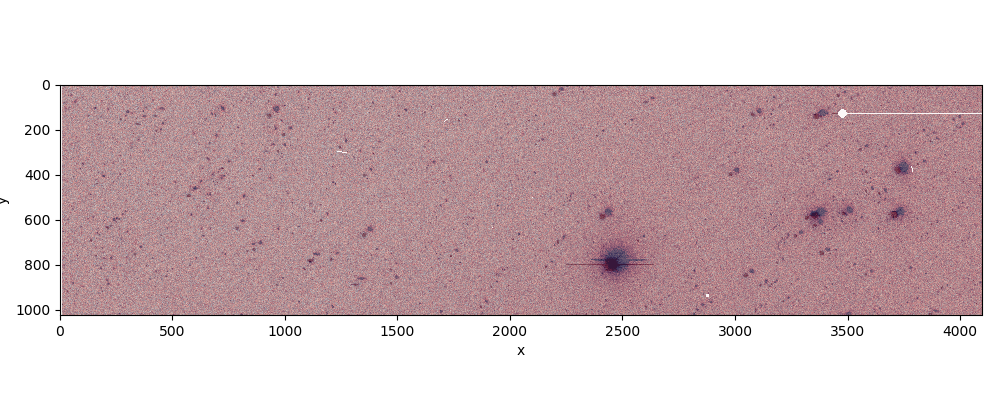

In [3]:
f1 = afits.open('wdd7.040920_0452.051_6.fits')
f2 = afits.open('wdd7.080104_0214.1025_6.fits')

f1wcs = WCS(f1[0].header)
f2wcs = WCS(f2[0].header)

zscaler = ZScaleInterval(nsamples=1000, contrast=0.25)

f1d = zscaler(f1[0].data)
f2d = zscaler(f2[0].data)

fig = figure(figsize=(10,4))
ax = fig.add_subplot(1,1,1)
ax.imshow(f1d.T, cmap='Reds')
ax.imshow(f2d.T, cmap='Blues', alpha=0.5)
tight_layout()
xlabel('x')
ylabel('y')
savefig('out/original_misalignment.pdf')

### Use the astrometry.net client (`solve-field`) to determine an accurate WCS solution for this field.

In [4]:
!solve-field -h

This program is part of the Astrometry.net suite.
For details, visit http://astrometry.net.
Git URL https://github.com/dstndstn/astrometry.net
Revision 0.73, date Thu_Nov_16_08:30:44_2017_-0500.

Usage:   solve-field [options]  [<image-file-1> <image-file-2> ...] [<xyls-file-1> <xyls-file-2> ...]

You can specify http:// or ftp:// URLs instead of filenames.  The "wget" or "curl" program will be used to retrieve the URL.

Options include:
  -h / --help: print this help message
  -v / --verbose: be more chatty -- repeat for even more verboseness
  -D / --dir <directory>: place all output files in the specified directory
  -o / --out <base-filename>: name the output files with this base name
  -b / --backend-config <filename>: use this config file for the
          "astrometry-engine" program
  --config <filename>: use this config file for the "astrometry-engine" program
  --batch: run astrometry-engine once, rather than once per input file
  -f / --files-on-stdin: read filenames to solve

### Options you might want to look at:

### `--ra`, `--dec` and `--radius`: Restrict the solution to some radius around RA and Dec. The regular telescope WCS should be plenty for an initial guess.

### `--scale-units`, `--scale-low` and `--scale-high`: You might not know the exact pixel scale (and it's a function of where you are on the detector in any case, but you also set limits from this based on the existing CD1_2, CD2_1

### `-D`, `-N`: Write to an output directory and write out a new FITS file with the solved WCS. 
# <u>Don't use out/ as the output directory.</u> 

### `--parity`: You can usually set this and get a speedup of 2x

### To get info from the header, you can use `astropy`, or just use `imhead` from the WCSTools package at the command line

In [5]:
print(WCS(f1[0].header))

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 38.355765019813  -8.9280976775107  
CRPIX : -1029.2364  4097.4406  
CD1_1 CD1_2  : -1.1704629057241e-07  7.40877225586965e-05  
CD2_1 CD2_2  : 7.43153648473077e-05  7.04796871082368e-07  
NAXIS : 1024  4096


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


### or

In [6]:
!imhead wdd7.040920_0452.051_6.fits

SIMPLE  =                    T / Fits standard
BITPIX  =                   16 /
NAXIS   =                    2 / Number of axes
NAXIS1  =                 1024 /
NAXIS2  =                 4096 /
EXTEND  =                    F / File may contain extensions
BSCALE  =             1.000000 /
BZERO   =         32768.000000 /
ORIGIN  = 'NOAO-IRAF FITS Image Kernel July 2003' / FITS file originator
DATE    = '2005-09-04T19:41:28' / Date FITS file was generated
IRAF-TLM= '15:41:27 (04/09/2005)' / Time of last modification
OBJECT  = 'wdd7    '           / Name of the object observed
NEXTEND =                    1 /
FILENAME= 'wdd7.040920_0452.051' / Original host filename
OBSTYPE = 'object  '           / Observation type
PREFLASH=             0.000000 / Preflash time (sec)
RADECSYS= 'FK5     '           / Default coordinate system
RADECEQ =                2000. / Default equinox
RA      = '02:33:25.68'        / RA of observation (hr)
DEC     = '-08:55:29.70'       / DEC of observation (deg)
COMM

### Use the above info to solve for the WCS for both images.

### The problem with the distortion polynomial that astronometry.net uses is that routines like ds9 ignore it. Look at astrometry.net's `wcs-to-tan` routine and convert the solved WCS to the tangent projection.

In [7]:
!wcs-to-tan -h

This program is part of the Astrometry.net suite.
For details, visit http://astrometry.net.
Git URL https://github.com/dstndstn/astrometry.net
Revision 0.73, date Thu_Nov_16_08:30:44_2017_-0500.

Usage: wcs-to-tan
   -w <WCS input file>
     [-e <extension>] FITS HDU number to read WCS from (default 0 = primary)
     [-t]: just use TAN projection, even if SIP extension exists.
     [-L]: force WCSlib
   [-x x-lo]
   [-y y-lo]
   [-W x-hi]
   [-H y-hi]
   [-N grid-n]
   -o <WCS output file>
   [-v]: verbose



### The commands I used are in Register_images_solution.txt and the output I generated in the out/ subdirectory.

In [8]:
!cat Register_images_solutions_commands.txt

solve-field --ra 38.35576501981 --dec -8.9280976775107 --radius 0.5 --scale-units arcsecperpix --scale-low 0.24 --scale-high 0.28 --fits-image wdd7.040920_0452.051_6.fits -N wdd7.040920_0452.051_6.solved.fits --parity pos
wcs-to-tan -w wdd7.040920_0452.051_6.wcs -t -o wdd7.040920_0452.051_6.wcs.tan

solve-field --ra 38.35576501981 --dec -8.9280976775107 --radius 0.5 --scale-units arcsecperpix --scale-low 0.24 --scale-high 0.28 --fits-image wdd7.080104_0214.1025_6.fits -N wdd7.080104_0214.1025_6.solved.fits --parity pos
wcs-to-tan -w wdd7.080104_0214.1025_6.wcs -t -o wdd7.080104_0214.1025_6.wcs.tan
